# Video labeling

The purpose of this notebook is to generate a dataframe where each row is a frame of a given video with its corresponding ground truth label.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import utils

In [19]:
# memorize all paths
videos_path = utils.videos_path
csv_path = utils.csv_path

In [20]:
# create dictionary of all phases
# we choose not to consider 'access' as it accounts for 0 frame
# we merge 'positioning suture' and 'positioning of suture' together
phase_dict = {
    'adhesiolysis' : 0,
    'peritoneal scoring' : 1,
    'preperitoneal dissection' : 2,
    'reduction of hernia' : 3,
    'mesh positioning' : 4,
    'mesh placement' : 5,
    'positioning suture' : 6,
    'direct hernia repair' : 7,
    'catheter insertion' : 8,
    'peritoneal closure' : 9,
    'transitionary idle' : 10,
    'stationary idle' : 11,
    'out of body' : 12,
    'blurry' : 13}

In [21]:
misspells = {
    'preperitoneal dissection' : ['preperitoneal dissection', 'preperioneal dissection', 'preperitoneal dissection', 
                                    'prepreitoneal dissection', 'prepetioneal dissection', 'prepertioneal dissection', 
                                    'perperitoneal dissection'],
    'positioning suture' : ['positioning suture', 'positioning of suture', 'acquiring suture', 'suture positioning', 
                                    'suture positioining', 'positioining suture'],
    'catheter insertion' : ['catheter insertion', 'cathter insertion'],
    'transitionary idle' : ['transitionary idle', 'transtionary idle', 'transtiionary idle', 'transitioning idle',
                                    'transitiionary idle', 'transtitionary idle'],
    'direct hernia repair' : ['direct hernia repair', 'primary hernia repair']
}

def invert_dict(d):
    inverted_dict = dict()
    for k, v in d.items():
        for w in v:
            inverted_dict[w] = k
    return inverted_dict

# format is : correct_ortho[misspell] = correct spelling
correct_ortho = invert_dict(misspells)

In [22]:
# read csv with dummy data annotation
dummy_annotation_df = pd.read_csv(csv_path)

# create dataframe with labels for every frame of all videos
labels_df = pd.DataFrame(columns = ['videoName', 'frame', 'label'])

In [23]:
integers = r'[0-9]'
trim_whitespaces = r'^[ \t]+|[ \t]+$'

def get_label(phaseName):
    # remove integers
    phaseName = re.sub(integers, '', phaseName)
    # remove trim whitespaces (begining or end of string)
    phaseName = re.sub(trim_whitespaces, '', phaseName)
    # lower everything
    phaseName = phaseName.lower()
    # get correct spelling
    if phaseName in correct_ortho.keys(): phaseName = correct_ortho[phaseName]
    label = phase_dict[phaseName]
    return label

In [24]:
videoNames, frames, labels = [], [], []

for index in range(dummy_annotation_df.shape[0]):

    # obtain row values
    videoName = dummy_annotation_df['videoName'][index]
    phaseName = dummy_annotation_df['PhaseName'][index]
    start = dummy_annotation_df['Start'][index]
    end = dummy_annotation_df['End'][index]

    if ':' in start and ':' in end: # verifies if it is indeed a time coded line

        # get corresponding label
        label = get_label(phaseName)
        frame_start = int(start[-5:-3]) * 60 + int(start[-2:])
        frame_end = int(end[-5:-3]) * 60 + int(end[-2:])
        # treat cases where the video is more than one hour long
        if len(start) > 5: frame_start += int(start[0:2]) * 3600
        if len(end) > 5: frame_end += int(end[0:2]) * 3600
        for frame in range(frame_start, frame_end):
            videoNames.append(videoName)
            frames.append(frame)
            labels.append(label)

# generate labels dataframe
labels_df = pd.DataFrame({'videoName' : videoNames, 'frame' : frames, 'label' : labels})

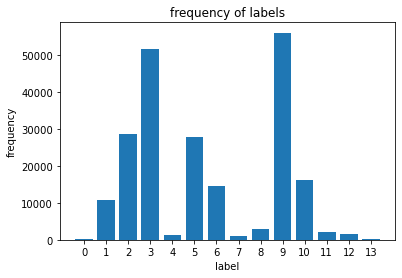

In [25]:
# plot histogram of labels
labels, counts = np.unique(labels_df['label'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title("frequency of labels")
plt.xlabel("label")
plt.ylabel("frequency")
plt.show()

Text(0.5, 1.0, 'Phases')

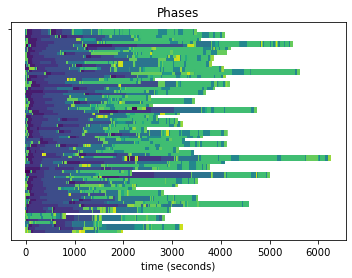

In [26]:
# plot phases
plt.scatter(x = labels_df['frame'], y = labels_df['videoName'], c = labels_df['label'], label = labels_df['label'], marker = '|')
plt.yticks('')
plt.xlabel('time (seconds)')
plt.title('Phases')

In [27]:
# save labels
labels_df.to_pickle('./labels/labels.pkl')